In [1]:
import random
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
# Read the dataset
def read_tsv(path):
    with open(path, 'r') as f:
        for line in f:
            userid, timestamp, artid, artname, traid, traname = line.strip().split('\t')
            yield userid, artid

data = list(read_tsv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv"))

In [2]:
# Process the original data to remove duplicate (user, artist) pairs
unique_user_artist_pairs = set()
processed_data = []
with tqdm(total=len(data), desc="Generating negatives", unit="entries") as pbar:
    for user, artid in data:
        if (user, artid) not in unique_user_artist_pairs:
            unique_user_artist_pairs.add((user, artid))
            processed_data.append((user, artid))
        pbar.update(1)

# `processed_data` now contains unique (user, artist) pairs
print(f"Original data size: {len(data)}")
print(f"Processed data size (unique user-artist pairs): {len(processed_data)}")

Generating negatives: 100%|██████████| 19150868/19150868 [00:04<00:00, 3832415.87entries/s]

Original data size: 19150868
Processed data size (unique user-artist pairs): 821011


In [3]:
data = processed_data
# Create user-to-artist mappings
user_to_artists = defaultdict(set)
for user, artist in data:
    user_to_artists[user].add(artist)

# Split dataset into training and validation
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

In [5]:
# Generate negative examples for validation
val_data_with_negatives = []
all_artists = set(artist for _, artist in data)
total_items = len(val_data)
with tqdm(total=total_items, desc="Generating negatives", unit="entries") as pbar:
    for user, artist in val_data:
        # Add the positive example
        val_data_with_negatives.append((user, artist, 1))  # Label 1 for positive

        # Generate a negative example with safeguards
        max_retries = 1000
        for _ in range(max_retries):
            negative_artist = random.choice(list(all_artists))
            if negative_artist not in user_to_artists[user]:
                val_data_with_negatives.append((user, negative_artist, 0))  # Label 0 for negative
                break
        else:
            print(f"Warning: Could not find a negative example for user {user} after {max_retries} retries.")

        # Update progress bar
        pbar.update(1)


# Display the sizes of the datasets
print(f"Training data size: {len(train_data)}")
print(f"Validation data size (with negatives): {len(val_data_with_negatives)}")

Generating negatives: 100%|██████████| 82102/82102 [02:34<00:00, 530.22entries/s]

Training data size: 738909
Validation data size (with negatives): 164204


In [6]:
import csv
# Save training set to a file
with open("train_data.tsv", "w", newline="") as train_file:
    writer = csv.writer(train_file, delimiter='\t')
    for user, artist in train_data:
        writer.writerow([user, artist])

# Save validation set (with negatives) to a file
with open("val_data.tsv", "w", newline="") as val_file:
    writer = csv.writer(val_file, delimiter='\t')
    for user, artist, label in val_data_with_negatives:
        writer.writerow([user, artist, label])

print(f"Training data saved to 'train_data.tsv'.")
print(f"Validation data saved to 'val_data.tsv'.")

Training data saved to 'train_data.tsv'.
Validation data saved to 'val_data.tsv'.


In [8]:
# Load the training set
def load_training_data(path):
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        return list(reader)

# Load the validation set
def load_validation_data(path):
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        return [(user, artist, int(label)) for user, artist, label in reader]

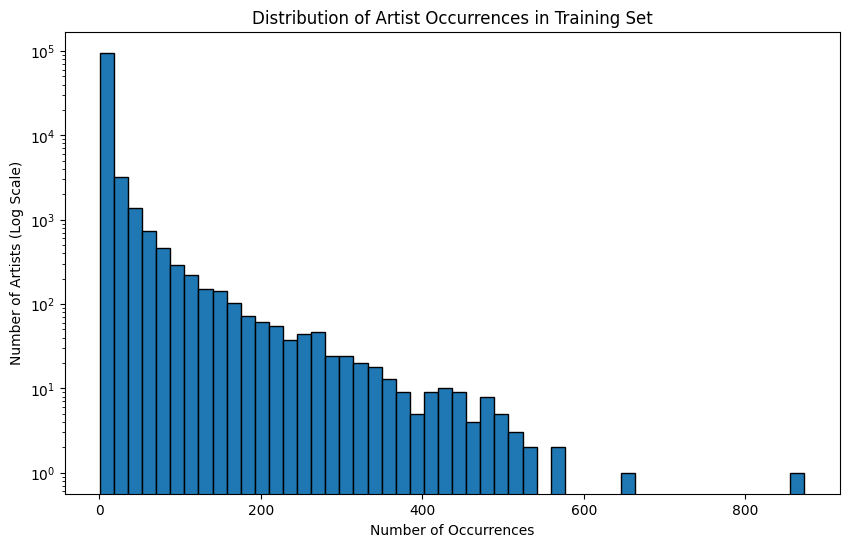

In [47]:
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

# Count artist occurrences
def get_artist_occurrences(train_data):
    artist_counts = Counter(artist for _, artist in train_data)
    return artist_counts

# Plot distribution
def plot_artist_distribution(artist_counts):
    counts = list(artist_counts.values())
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=50, edgecolor="k")
    plt.yscale('log')  # Log scale for better visualization of skewed data
    plt.title("Distribution of Artist Occurrences in Training Set")
    plt.xlabel("Number of Occurrences")
    plt.ylabel("Number of Artists (Log Scale)")
    plt.show()

# Main
train_data = load_training_data("train_data.tsv")
artist_counts = get_artist_occurrences(train_data)
plot_artist_distribution(artist_counts)

In [36]:
val_data = load_validation_data("val_data.tsv")

In [46]:
from sklearn.metrics import accuracy_score

# Get popularity thresholds
def get_popularity_thresholds(artist_counts, percentages):
    sorted_artists = sorted(artist_counts.items(), key=lambda x: x[1], reverse=True)
    thresholds = {}
    total_artists = len(sorted_artists)
    
    for pct in percentages:
        cutoff_index = int(total_artists * (pct / 100))
        thresholds[pct] = sorted_artists[cutoff_index - 1][1] if cutoff_index > 0 else 0
    return thresholds

# Predict based on popularity
def predict_popularity(val_data, artist_counts, threshold):
    popular_artists = {artist for artist, count in artist_counts.items() if count >= threshold}
    predictions = [1 if artist in popular_artists else 0 for _, artist, _ in val_data]
    return predictions

# Evaluate thresholds
def evaluate_thresholds(val_data, artist_counts, thresholds):
    results = {}
    y_true = [label for _, _, label in val_data]
    
    for pct, threshold in thresholds.items():
        y_pred = predict_popularity(val_data, artist_counts, threshold)
        accuracy = accuracy_score(y_true, y_pred)
        results[pct] = accuracy
    return results

# Define thresholds for top 10%, 20%, 30%, and 50%
percentages = [5, 10, 15, 20]
thresholds = get_popularity_thresholds(artist_counts, percentages)

# Evaluate performance
results = evaluate_thresholds(val_data, artist_counts, thresholds)

# Print results
print("Performance on Validation Set:")
for pct, accuracy in results.items():
    print(f"Top {pct}% Artists: Accuracy = {accuracy:.4f}")


Performance on Validation Set:
Top 5% Artists: Accuracy = 0.7445
Top 10% Artists: Accuracy = 0.7816
Top 15% Artists: Accuracy = 0.7898
Top 20% Artists: Accuracy = 0.7881


In [38]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

# Load training data and build artist-to-users mapping
def build_artist_user_mapping(train_data):
    artist_users = defaultdict(set)
    for user, artist in train_data:
        artist_users[artist].add(user)
    return artist_users

# Calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

# Predict based on Jaccard similarity
def predict_jaccard(val_data, train_user_artists, artist_users, threshold):
    predictions = []
    for user, artist, _ in val_data:
        user_artists = train_user_artists.get(user, set())
        max_similarity = 0
        for user_artist in user_artists:
            if user_artist == artist:
                continue
            similarity = jaccard_similarity(artist_users[artist], artist_users[user_artist])
            max_similarity = max(max_similarity, similarity)
        predictions.append(1 if max_similarity >= threshold else 0)
    return predictions

# Build mappings
train_user_artists = defaultdict(set)
for user, artist in train_data:
    train_user_artists[user].add(artist)

artist_users = build_artist_user_mapping(train_data)
# Evaluate performance
def evaluate_jaccard(val_data, thresholds):

    # Evaluate thresholds
    results = {}
    y_true = [label for _, _, label in val_data]

    for threshold in thresholds:
        y_pred = predict_jaccard(val_data, train_user_artists, artist_users, threshold)
        accuracy = accuracy_score(y_true, y_pred)
        results[threshold] = accuracy

    return results

In [39]:
# Evaluate for thresholds
thresholds = [0.15]
results = evaluate_jaccard(val_data[:5000], thresholds)

# Print results
print("Performance on Validation Set:")
for threshold, accuracy in results.items():
    print(f"Threshold: {threshold}, Accuracy = {accuracy:.4f}")

Performance on Validation Set:
Threshold: 0.15, Accuracy = 0.6840


In [40]:
from itertools import product

# Predict based on combined popularity and Jaccard similarity
def predict_combined(val_data, train_user_artists, artist_users, popularity_set, jaccard_threshold):
    predictions = []
    for user, artist, _ in val_data:
        # Check if the artist is popular
        if artist in popularity_set:
            predictions.append(1)
            continue
        # Check Jaccard similarity
        user_artists = train_user_artists.get(user, set())
        max_similarity = 0
        for user_artist in user_artists:
            if user_artist == artist:
                continue
            similarity = jaccard_similarity(artist_users[artist], artist_users[user_artist])
            max_similarity = max(max_similarity, similarity)

        predictions.append(1 if max_similarity >= jaccard_threshold else 0)

    return predictions

# Evaluate combined model
def evaluate_combined(val_data, popularity_percent, jaccard_thresholds):

    results = {}
    y_true = [label for _, _, label in val_data]
    popularity_thresholds = [a for _,a in get_popularity_thresholds(artist_counts, popularity_percent).items()]
    

    for pop_thresh, jac_thresh in product(popularity_thresholds, jaccard_thresholds):
        # Determine popular artists
        popularity_set = {artist for artist, count in artist_counts.items() if count >= pop_thresh}

        # Predict using the combined model
        y_pred = predict_combined(val_data, train_user_artists, artist_users, popularity_set, jac_thresh)

        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        results[(pop_thresh, jac_thresh)] = accuracy

    return results

# Define thresholds
popularity_percent = [15]  # Top 10%, 20%, etc.
jaccard_thresholds = [0.8]

# Evaluate performance
results = evaluate_combined(val_data[:5000], popularity_percent, jaccard_thresholds)

# Print results
print("Performance on Validation Set (Popularity and Jaccard):")
for (pop_thresh, jac_thresh), accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"Popularity Threshold: {pop_thresh}, Jaccard Threshold: {jac_thresh}, Accuracy = {accuracy:.4f}")


Performance on Validation Set (Popularity and Jaccard):
Popularity Threshold: 8, Jaccard Threshold: 0.8, Accuracy = 0.8090
